# Market Basket Analysis on Pharmacy Sales Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [2]:
#pip install mlxtend

In this project, we are performing Masket Basket Analysis to identify the items frequently bought together in a Retail Pharmacy Store in India. We are using metrics - support, confidence and lift to perform this.

The dataset consists of Sales data for 4 quaters (or a year). 

### Data Input

In [3]:
#Importing the dataset
Q1=pd.read_csv("Report 22-23 Q1.csv")
Q2=pd.read_csv("Report 22-23 Q2.csv")
Q3=pd.read_csv("Report 22-23 Q3.csv")
Q4=pd.read_csv("Report 22-23 Q4.csv")

/var/folders/fb/4nblzmwx151cycy98sm5fwqw0000gn/T/ipykernel_46813/2148948536.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  Q3=pd.read_csv("Report 22-23 Q3.csv")
/var/folders/fb/4nblzmwx151cycy98sm5fwqw0000gn/T/ipykernel_46813/2148948536.py:5: DtypeWarning: Columns (7,29) have mixed types. Specify dtype option on import or set low_memory=False.
  Q4=pd.read_csv("Report 22-23 Q4.csv")


In [4]:
#Concatinating
salesdata_22_23=pd.concat([Q1,Q2,Q3,Q4])

In [5]:
#salesdata_22_23.to_excel("salesdata_22_23.xlsx")

In [6]:
salesdata_22_23.shape

(331550, 32)

In [7]:
salesdata_22_23.head()

,c_inv_br_code,customer_name,invno,invdate,lc_code,cust_code,lc_name,c_mobile,itemcode,itemname,...,n_sale_vat,n_epr,n_pur_vat,n_purvalue,n_purvat,n_epr_vat,n_margin,n_margin_per,c_pur_supplier,c_pur_tran
0,199:199,BEST PRICE PHARMACY,199/23/T/1,01/04/23,NaN,CU0087,BEST PRICE PHARMACY,NaN,I15670,EVAPARIN 300 CAR PFS-KIT,...,12999.98,1504.76,NaN,10533.32,NaN,0.0,12999.98,129.9998,OPENEING OR GRN,///
1,199:199,GENERAL CUSTOMER,199/23/S/2127,06/04/23,NaN,GC01,CH.SOWJANYA,9533755885.0,I15670,EVAPARIN 300 CAR PFS-KIT,...,4380.94,1504.76,NaN,3009.52,NaN,0.0,4380.94,43.8094,OPENEING OR GRN,///
2,199:199,GENERAL CUSTOMER,199/23/S/2353,06/04/23,-,GC01,ANUSHA,9441270048.0,I15670,EVAPARIN 300 CAR PFS-KIT,...,2190.47,1504.76,NaN,1504.76,NaN,0.0,2190.47,21.9047,OPENEING OR GRN,///
3,199:199,GENERAL CUSTOMER,199/23/S/5678,14/04/23,NaN,GC01,CH. SOWJANYA,9533755885.0,I15670,EVAPARIN 300 CAR PFS-KIT,...,2190.47,1504.76,NaN,1504.76,NaN,0.0,2190.47,21.9047,OPENEING OR GRN,///
4,199:199,GENERAL CUSTOMER,199/23/S/7887,20/04/23,NaN,GC01,ANUSHA,NaN,I15670,EVAPARIN 300 CAR PFS-KIT,...,2190.47,1504.76,NaN,1504.76,NaN,0.0,2190.47,21.9047,OPENEING OR GRN,///


This dataset consists of 32 columns and 331550 rows

In [8]:
#Dropping all the unwanted columns
salesdata_22_23.drop(['c_inv_br_code', 'customer_name','lc_code','cust_code','c_mobile','batchno','n_inv_tax','n_vat_after_disc','n_invvat_amt','n_sale_vat','n_epr','n_pur_vat','n_purvalue','n_purvat','n_epr_vat','n_margin','n_margin_per','c_pur_supplier','c_pur_tran','lc_name','c_mfac_name','saleqty','salefreeqty','salerate','n_gross_sale','n_discper','n_disc_amt'], axis=1,inplace=True)

In [9]:
salesdata_22_23.shape

(331550, 5)

In [10]:
salesdata_22_23.head()

,invno,invdate,itemcode,itemname,n_net_sales
0,199/23/T/1,01/04/23,I15670,EVAPARIN 300 CAR PFS-KIT,12999.98
1,199/23/S/2127,06/04/23,I15670,EVAPARIN 300 CAR PFS-KIT,4380.94
2,199/23/S/2353,06/04/23,I15670,EVAPARIN 300 CAR PFS-KIT,2190.47
3,199/23/S/5678,14/04/23,I15670,EVAPARIN 300 CAR PFS-KIT,2190.47
4,199/23/S/7887,20/04/23,I15670,EVAPARIN 300 CAR PFS-KIT,2190.47


Each row is an item in a transaction. If a transaction consists of 5 items - they would be in 5 rows.

invno - invoice number
invdate - date of the transaction, invoice date
itemcode - unique id of an item
itemname- name of the item
n_net_sale - total selling price of the item.

In [11]:
#Checking for null values
salesdata_22_23.isnull().sum()

invno          0
invdate        0
itemcode       0
itemname       0
n_net_sales    0
dtype: int64

### Data Cleaning

In [12]:
#Removing transactions which have T in invoice number(they are not B2C sales, they are B2B sales) 
discard="T"
salesdata_22_23=salesdata_22_23[~salesdata_22_23.invno.str.contains('|'.join(discard))]


#Removing transactions where n_net_sales value is less than 0 as they are returns

salesdata_22_23=salesdata_22_23[salesdata_22_23['n_net_sales']>0]

In [13]:
salesdata_22_23.shape

(328310, 5)

### EDA

In [14]:
salesdata_22_23.head()

,invno,invdate,itemcode,itemname,n_net_sales
1,199/23/S/2127,06/04/23,I15670,EVAPARIN 300 CAR PFS-KIT,4380.94
2,199/23/S/2353,06/04/23,I15670,EVAPARIN 300 CAR PFS-KIT,2190.47
3,199/23/S/5678,14/04/23,I15670,EVAPARIN 300 CAR PFS-KIT,2190.47
4,199/23/S/7887,20/04/23,I15670,EVAPARIN 300 CAR PFS-KIT,2190.47
5,199/23/S/9319,24/04/23,I15670,EVAPARIN 300 CAR PFS-KIT,8761.88


Removed around 3k rows in the first part of cleaning.

In [15]:
#Checking for unique number of items
salesdata_22_23['itemcode'].nunique()

12963

There are 12k number of items.

In [16]:
#Total number of unique transactions
salesdata_22_23['invno'].nunique()

124164

There are 124k unique items

In [17]:
#Counting number of items in each transaction and putting it in a new dataframe
itemcount=salesdata_22_23.groupby(['invno'])['itemcode'].count()
itemcount=pd.DataFrame(itemcount)
itemcount.reset_index(inplace=True)
itemcount

,invno,itemcode
0,199/22/S/100000,1
1,199/22/S/100001,1
2,199/22/S/100002,1
3,199/22/S/100003,2
4,199/22/S/100004,4
...,...,...
124159,199/23/S/9995,4
124160,199/23/S/9996,6
124161,199/23/S/9997,1
124162,199/23/S/9998,1


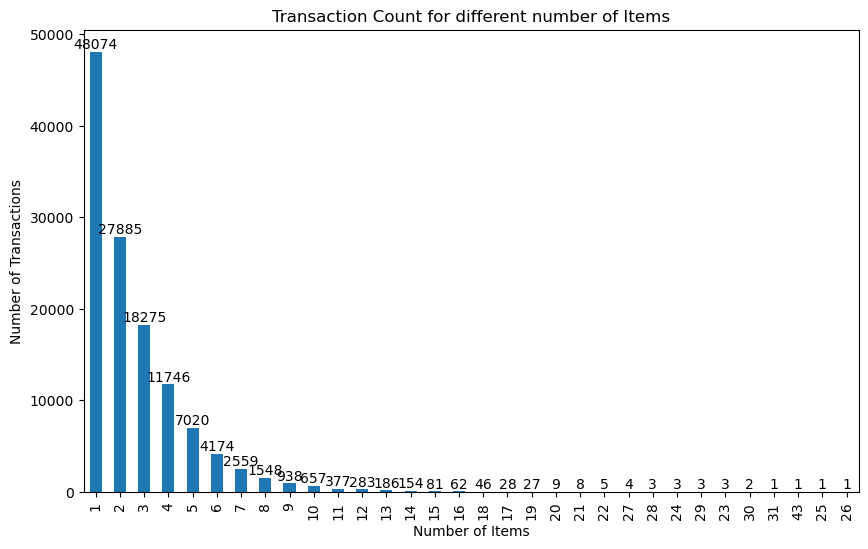

In [18]:
item_counts=itemcount['itemcode'].value_counts()

# Plot the item counts
plt.figure(figsize=(10, 6))  # Set the figure size
item_counts.plot(kind='bar')  # Plot the bar chart
plt.xlabel('Number of Items')  # Set the x-axis label
plt.ylabel('Number of Transactions')  # Set the y-axis label
plt.title('Transaction Count for different number of Items')  # Set the title

for i, v in enumerate(item_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()  # Show the plot

Item count ranges from 1 to 26; with number of transactions decreasing as the count is increasing, there are 47k with only one item - and less than 100 transactions for item count of more than 15. Need to remove these for a more concise data

In [19]:
# Dropping all transactions with only one item and more than 15 as they won't be suitable for this analysis
invoices_with_unwanted_itemcount = itemcount[(itemcount['itemcode'] == 1)|(itemcount['itemcode'] >=15)]['invno']

# Creating a boolean mask for rows to be dropped
mask = np.logical_not(salesdata_22_23['invno'].isin(invoices_with_unwanted_itemcount))


In [20]:
salesdata_22_23_new=salesdata_22_23[mask]

In [21]:
salesdata_22_23_new.shape

(275149, 5)

##Extracting this sales data, and utilized while analyzing for diabetic medicines
#salesdata_22_23.to_excel("salesdata_22_23.xlsx")

There are 275149 rows now, after removing almost 50k rows.

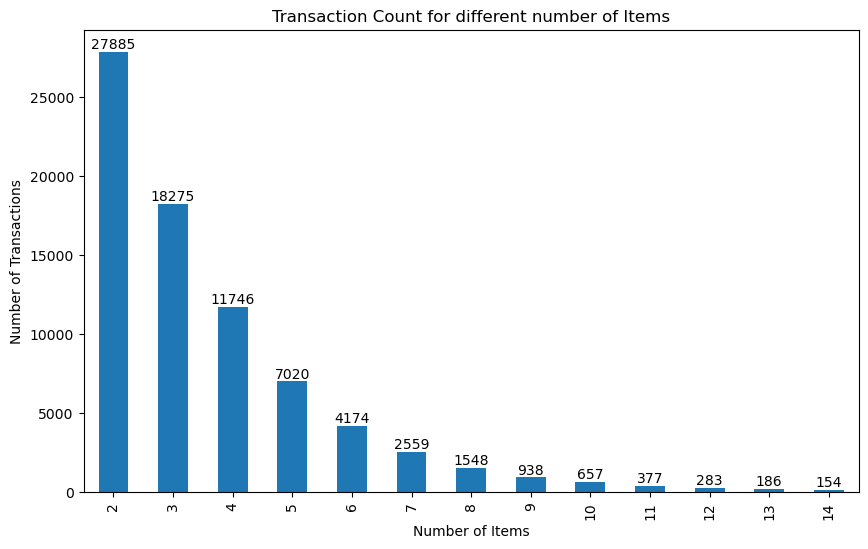

In [22]:
#Checking the itemcount in new dataframe for verification.
itemcount2=salesdata_22_23_new.groupby(['invno'])['itemcode'].count()
itemcount2=pd.DataFrame(itemcount2)
itemcount2.reset_index(inplace=True)

item_counts=itemcount2['itemcode'].value_counts()

# Plot the item counts
plt.figure(figsize=(10, 6))  # Set the figure size
item_counts.plot(kind='bar')  # Plot the bar chart
plt.xlabel('Number of Items')  # Set the x-axis label
plt.ylabel('Number of Transactions')  # Set the y-axis label
plt.title('Transaction Count for different number of Items')  # Set the title

for i, v in enumerate(item_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()  # Show the plot

This is still a lot of data for performing Market Basket Analysis. It is important to extract most meaningful part for the analysis to make sure correct results are yielded. 

In [23]:
#Observing the unique values of all the columns
salesdata_22_23.nunique(axis=0)

invno          124164
invdate           285
itemcode        12963
itemname        12963
n_net_sales     45036
dtype: int64

There are 12k unique items. Extracting the important items based on the frequency.

In [24]:
item_frequency=salesdata_22_23_new.groupby(['itemcode'])['itemcode'].count()

item_frequency=item_frequency.sort_values(ascending=False)

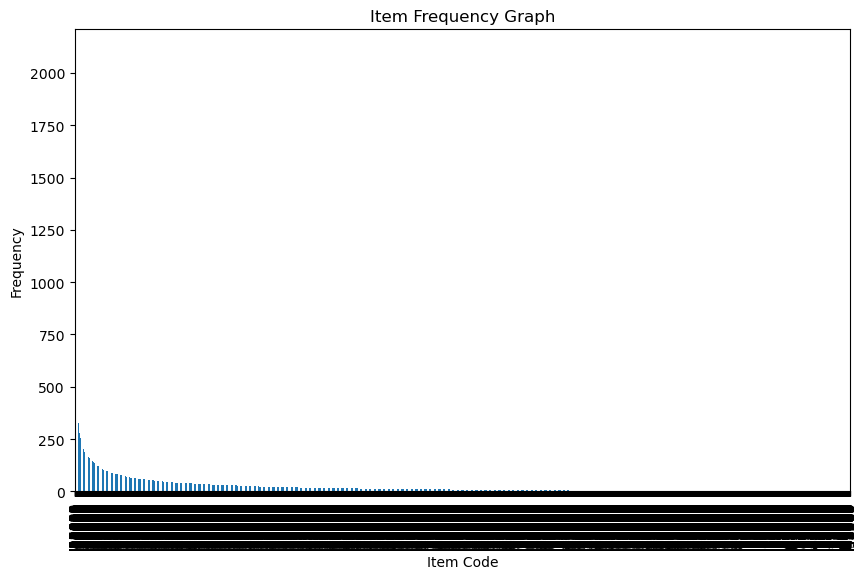

In [25]:
plt.figure(figsize=(10, 6))
item_frequency.plot(kind='bar')
plt.xlabel('Item Code')
plt.ylabel('Frequency')
plt.title('Item Frequency Graph')
plt.show()

In [26]:
print("Maximum ", item_frequency.max(), "Minimum ",item_frequency.min())

Maximum  2103 Minimum  1


The frequency of items is ranging from 1 to 2103. Choosing the top 50 items as after that their frenquency is reducing reasonably.

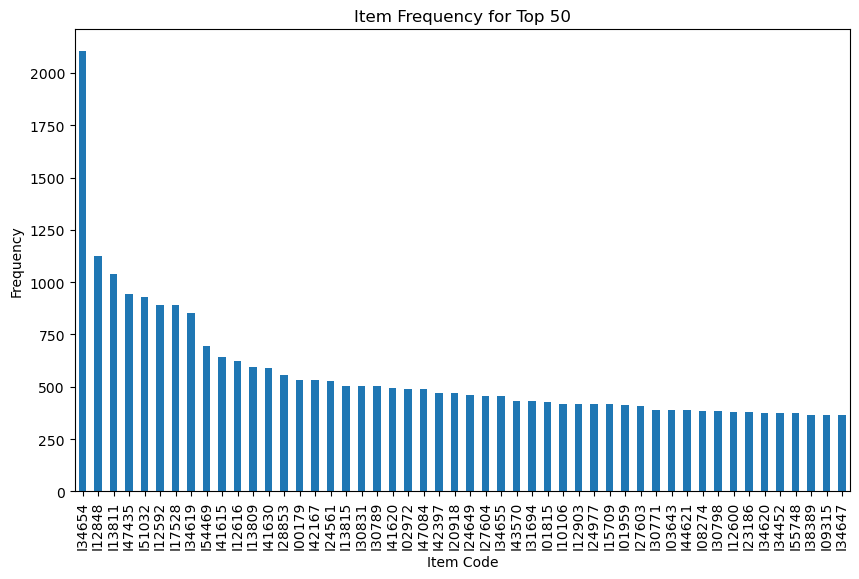

In [27]:
item_frequency_top50=item_frequency.sort_values(ascending=False).head(50)

plt.figure(figsize=(10, 6))
item_frequency_top50.plot(kind='bar')
plt.xlabel('Item Code')
plt.ylabel('Frequency')
plt.title('Item Frequency for Top 50')


plt.show()



### Data Extraction

In [28]:
#Choosing transactions which consists of these 50 items only
df_item_frequency = pd.DataFrame({'itemcode': item_frequency_top50.index, 'frequency': item_frequency_top50.values})

mask2 = salesdata_22_23_new['itemcode'].isin(df_item_frequency['itemcode'])

salesdata_22_23_new2=salesdata_22_23_new[mask2]
salesdata_22_23_new2.reset_index(drop=True,inplace=True)

salesdata_22_23_new2.shape

(28047, 5)

In [29]:
salesdata_22_23_new2['itemcode'].nunique()

50

In [30]:
#Extracting item table to map item code and item name

item_index=salesdata_22_23_new2.drop(['invno','invdate','n_net_sales'],axis=1)
item_index.drop_duplicates(inplace=True)
item_index.reset_index(drop=True,inplace=True)
item_index

,itemcode,itemname
0,I34654,PANTOP-40MG TAB-15*S
1,I41615,SHELCAL 500MG-15T
2,I23186,KIDRICH D3 DROPS-15ML
3,I12592,D2DISPOVAN SYRINGE-2ML
4,I20918,HIFENAC-P TAB 15 S
5,I34647,PANTOP DSR-10
6,I38389,RAZO D CAPS-15*S
7,I00179,ACECLO PLUS TAB 15S
8,I30789,NEXPRO 40MG TAB-15S
9,I24561,LIBEROCAL D3 TAB-4'S


### Data Manipulation

In [31]:
#Converting the transactional sales dataset into the required format suitable for the Market Basket Analysis and using library mlxtend

transaction_wise=salesdata_22_23_new2.pivot_table(values='n_net_sales',index=['invno'], columns='itemcode',aggfunc='count',fill_value=0)


In [32]:
#Transaction wise table
transaction_wise

itemcode,I00179,I01815,I01959,I02972,I03643,I08274,I09315,I10106,I12592,I12600,...,I41630,I42167,I42397,I43570,I44621,I47084,I47435,I51032,I54469,I55748
invno,,,,,,,,,,,,,,,,,,,,,
199/22/S/100008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199/22/S/100011,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199/22/S/100012,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199/22/S/100013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199/22/S/100015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199/23/S/998,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
199/23/S/9982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199/23/S/9985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#As we only want information about whether an item has been purchased or not but not its count in a transaction, 
# we are replacing any values greater than 1 with 1 
transaction_wise.clip(upper=1, inplace=True)

In [34]:
#Converting the Transaction wise pivot table to a Dataframe
df = pd.DataFrame(transaction_wise, columns=transaction_wise.columns)

### Data Analysis Market Basket

Once the dataset is ready we calculate the support and confidence to find out the frequent itemsets and use lift to calculate the rules.

Briefly about support, confidence and lift : 

1. Support:
It refers to the frequency or occurrence of an item or itemset in the dataset.

Formula: Support(A) = (Number of transactions containing A) / (Total number of transactions)

2. Confidence:
It measures the likelihood of one item or itemset occurring given the occurrence of another item or itemset. 

Formula: Confidence(A -> B) = (Number of transactions containing both A and B) / (Number of transactions containing A)

3. Lift:
It measures the degree of association or dependency between two items or itemsets. It compares the observed support of both items occurring together to the expected support if they were independent of each other.

Formula: Lift(A -> B) = (Support(A and B)) / (Support(A) * Support(B))

Using a suitable Python library like mlxtend (for using apyori) to perform association rule mining : 

#### Calculating Frequent Itemsets
The first step is to identify frequent itemsets, which are sets of items that appear together in a significant number of transactions. This is done by scanning the dataset and counting the support (frequency) of each item or combination of items.


##### Metric value
As there are about 21k transactions and with 50 items - the sparsitry is high. 
For this reason support of 0.001 has to be used (that is considering all items which pertain to at least 0.1% of all the transactions)
Using support of 0.1 (10%) led to 0 frequent itemsets and or 0.01 (1%) led to only 50 frequent item sets and they mostly consisted of single items.

In [35]:
#Calculating the frequent itemset using the apriori function
frequent_itemsets = apriori(df, min_support=0.001, use_colnames=True,max_len=2)

# Print the frequent itemsets
print(frequent_itemsets)

/Users/poojithavijjapu/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


      support          itemsets
0    0.025093          (I00179)
1    0.019998          (I01815)
2    0.019236          (I01959)
3    0.022807          (I02972)
4    0.018189          (I03643)
..        ...               ...
123  0.001286  (I51032, I41620)
124  0.002714  (I41630, I51032)
125  0.001143  (I51032, I43570)
126  0.001381  (I47084, I47435)
127  0.001381  (I51032, I47435)

[128 rows x 2 columns]


In [36]:
frequent_itemsets.tail
(50)

50

We obtained 128 frequent item sets consisting of one and two itemsets. For this project we are analyzing only those rules with one antecedant and one consequent, hence we set the max_len of itemset to 2.

#### Calculating Rules
Next, from the frequent itemsets, association rules are generated. An association rule consists of an antecedent (left-hand side) and a consequent (right-hand side) itemset. These rules represent relationships between items or itemsets based on their co-occurrence in transactions.

We are utilizing the 128 frequent itemsets formed above to calculate the rules. 


##### Which metric and why?
We can use minimum confidence or lift as a metric to filter out the rules. 

Confidence only gives strenght of association between two elements, and lift gives the degree of association or dependency between two items if they were independent of each other.

In simpler words, for a rule A-> B confidence only tells frequency of occurance of B when A occurs, whereas Lift gives information about occurance of A and B together in comparision with their individual occurances - this gives more value if these items are really desired together.

Hence we are using 'Lift'

##### Metric Value

A lift value greater than 1 indicates a positive association, suggesting that the occurrence of item B is more likely when item A is present compared to when they are independent of each other. A lift value of 1 indicates independence, while a lift value less than 1 suggests a negative association or avoidance.

In [37]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=4)

In [38]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(I01959),(I54469),0.019236,0.032759,0.006190,0.321782,9.822775,0.005560,1.426151,0.915813
1,(I54469),(I01959),0.032759,0.019236,0.006190,0.188953,9.822775,0.005560,1.209257,0.928616
2,(I02972),(I30831),0.022807,0.023569,0.003857,0.169102,7.174720,0.003319,1.175152,0.880708
3,(I30831),(I02972),0.023569,0.022807,0.003857,0.163636,7.174720,0.003319,1.168383,0.881396
4,(I08274),(I03643),0.017855,0.018189,0.001952,0.109333,6.011044,0.001627,1.102333,0.848795
5,(I03643),(I08274),0.018189,0.017855,0.001952,0.107330,6.011044,0.001627,1.100232,0.849083
6,(I09315),(I13809),0.016998,0.027712,0.004142,0.243697,8.794045,0.003671,1.285581,0.901613
7,(I13809),(I09315),0.027712,0.016998,0.004142,0.149485,8.794045,0.003671,1.155772,0.911547
8,(I10106),(I24977),0.019855,0.019617,0.005238,0.263789,13.446835,0.004848,1.331660,0.944384
9,(I24977),(I10106),0.019617,0.019855,0.005238,0.266990,13.446835,0.004848,1.337151,0.944155


In [39]:
top25=rules.sort_values(by='lift',ascending=False).head(25)

In [40]:
top25

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
22,(I42167),(I12616),0.025140,0.029378,0.012999,0.517045,17.599657,0.012260,2.009758,0.967504
23,(I12616),(I42167),0.029378,0.025140,0.012999,0.442464,17.599657,0.012260,1.748513,0.971728
8,(I10106),(I24977),0.019855,0.019617,0.005238,0.263789,13.446835,0.004848,1.331660,0.944384
9,(I24977),(I10106),0.019617,0.019855,0.005238,0.266990,13.446835,0.004848,1.337151,0.944155
29,(I30789),(I24977),0.023093,0.019617,0.004523,0.195876,9.984936,0.004070,1.219194,0.921121
28,(I24977),(I30789),0.019617,0.023093,0.004523,0.230583,9.984936,0.004070,1.269671,0.917855
10,(I10106),(I30789),0.019855,0.023093,0.004571,0.230216,9.969057,0.004112,1.269066,0.917915
11,(I30789),(I10106),0.023093,0.019855,0.004571,0.197938,9.969057,0.004112,1.222031,0.920957
1,(I54469),(I01959),0.032759,0.019236,0.006190,0.188953,9.822775,0.005560,1.209257,0.928616
0,(I01959),(I54469),0.019236,0.032759,0.006190,0.321782,9.822775,0.005560,1.426151,0.915813


In [41]:
#Converting the frozen sets of antecedents and consequents into proper lists suitable for operations

top25['antecedents']=top25['antecedents'].apply(lambda x: str(list(x)))
top25['consequents']=top25['consequents'].apply(lambda x: str(list(x)))

antecedents=[]
for i in top25['antecedents']:
    antecedents.append(i[2:8])
    
consequents=[]
for i in top25['consequents']:
    consequents.append(i[2:8])

top25['antecedents_id']=antecedents
top25['consequents_id']=consequents

In [42]:
#Adding Item name to the top 25 list to make it more suitable for interpretation

#For antecedents 
merged_table = pd.merge(top25, item_index, left_on='antecedents_id', right_on='itemcode', how='left')

# Drop the redundant 'itemcode' column from the merged table
merged_table.drop('itemcode', axis=1, inplace=True)

# Rename the 'itemname' column to 'antecedents_name'
merged_table.rename(columns={'itemname': 'antecedents_name'}, inplace=True)



In [43]:
#For consequents

merged_table = pd.merge(merged_table, item_index, left_on='consequents_id', right_on='itemcode', how='left')

# Drop the redundant 'itemcode' column from the merged table
merged_table.drop('itemcode', axis=1, inplace=True)

# Rename the 'itemname' column to 'antecedents_name'
merged_table.rename(columns={'itemname': 'consequents_name'}, inplace=True)


In [44]:
merged_table

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_id,consequents_id,antecedents_name,consequents_name
0,['I42167'],['I12616'],0.025140,0.029378,0.012999,0.517045,17.599657,0.012260,2.009758,0.967504,I42167,I12616,NS100ML SODIUM CHLORIDE,D10 ML DISPOVAN SYRINGE
1,['I12616'],['I42167'],0.029378,0.025140,0.012999,0.442464,17.599657,0.012260,1.748513,0.971728,I12616,I42167,D10 ML DISPOVAN SYRINGE,NS100ML SODIUM CHLORIDE
2,['I10106'],['I24977'],0.019855,0.019617,0.005238,0.263789,13.446835,0.004848,1.331660,0.944384,I10106,I24977,COR-3 TAB -15 S,LIVOGEN Z TAB-15S
3,['I24977'],['I10106'],0.019617,0.019855,0.005238,0.266990,13.446835,0.004848,1.337151,0.944155,I24977,I10106,LIVOGEN Z TAB-15S,COR-3 TAB -15 S
4,['I30789'],['I24977'],0.023093,0.019617,0.004523,0.195876,9.984936,0.004070,1.219194,0.921121,I30789,I24977,NEXPRO 40MG TAB-15S,LIVOGEN Z TAB-15S
5,['I24977'],['I30789'],0.019617,0.023093,0.004523,0.230583,9.984936,0.004070,1.269671,0.917855,I24977,I30789,LIVOGEN Z TAB-15S,NEXPRO 40MG TAB-15S
6,['I10106'],['I30789'],0.019855,0.023093,0.004571,0.230216,9.969057,0.004112,1.269066,0.917915,I10106,I30789,COR-3 TAB -15 S,NEXPRO 40MG TAB-15S
7,['I30789'],['I10106'],0.023093,0.019855,0.004571,0.197938,9.969057,0.004112,1.222031,0.920957,I30789,I10106,NEXPRO 40MG TAB-15S,COR-3 TAB -15 S
8,['I54469'],['I01959'],0.032759,0.019236,0.006190,0.188953,9.822775,0.005560,1.209257,0.928616,I54469,I01959,RECITA FORTE TAB<15S>,AMIXIDE-H TABS-10*S
9,['I01959'],['I54469'],0.019236,0.032759,0.006190,0.321782,9.822775,0.005560,1.426151,0.915813,I01959,I54469,AMIXIDE-H TABS-10*S,RECITA FORTE TAB<15S>


In [45]:
market_basket=merged_table[['antecedents_id','antecedents_name','consequents_id','consequents_name','lift','confidence']]

In [46]:
market_basket

,antecedents_id,antecedents_name,consequents_id,consequents_name,lift,confidence
0,I42167,NS100ML SODIUM CHLORIDE,I12616,D10 ML DISPOVAN SYRINGE,17.599657,0.517045
1,I12616,D10 ML DISPOVAN SYRINGE,I42167,NS100ML SODIUM CHLORIDE,17.599657,0.442464
2,I10106,COR-3 TAB -15 S,I24977,LIVOGEN Z TAB-15S,13.446835,0.263789
3,I24977,LIVOGEN Z TAB-15S,I10106,COR-3 TAB -15 S,13.446835,0.266990
4,I30789,NEXPRO 40MG TAB-15S,I24977,LIVOGEN Z TAB-15S,9.984936,0.195876
5,I24977,LIVOGEN Z TAB-15S,I30789,NEXPRO 40MG TAB-15S,9.984936,0.230583
6,I10106,COR-3 TAB -15 S,I30789,NEXPRO 40MG TAB-15S,9.969057,0.230216
7,I30789,NEXPRO 40MG TAB-15S,I10106,COR-3 TAB -15 S,9.969057,0.197938
8,I54469,RECITA FORTE TAB<15S>,I01959,AMIXIDE-H TABS-10*S,9.822775,0.188953
9,I01959,AMIXIDE-H TABS-10*S,I54469,RECITA FORTE TAB<15S>,9.822775,0.321782


This is the list of items that are related, which can be used by stakeholders for different purposes.